In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from pprint import pprint

from PIL import Image
Image.MAX_IMAGE_PIXELS = 1000000000

import matplotlib.pyplot as plt
%matplotlib inline

# Extract total number of cars and total area at each city of COWC

In [2]:
city_root = "../../data/cowc_cities"

cities = os.listdir(city_root)
print(cities)    

['Columbus_CSUAV_AFRL.txt', 'Potsdam_ISPRS.txt', 'Selwyn_LINZ.txt', 'Toronto_ISPRS.txt', 'Utah_AGRC.txt', 'Vaihingen_ISPRS.txt']


In [3]:
def extract_scene_stats(scene, px2kilometer=0.15 * 0.001):
    
    annotation = Image.open(scene)
    annotation = np.array(annotation)
    
    h, w, _ = annotation.shape
    
    area_km2 = (h * px2kilometer) * (w * px2kilometer)
    
    cars = (annotation[:, :, 0] > 0).sum()
    
    return {'area [km^2]': area_km2, 'cars': cars}


def extract_city_stats(data_root, scenes, sum_scenes=True):
    
    city_stats = {}
    
    for scene in scenes:
        
        annotation_file = scene + "_Annotated_Cars.png"
        scene_stats = extract_scene_stats(os.path.join(data_root, annotation_file))
        
        city_stats[os.path.basename(scene)] = scene_stats
        
    if sum_scenes:
        area_km2 = 0.0
        cars = 0
        
        for scene_stats in city_stats.values():
            area_km2 += scene_stats['area [km^2]']
            cars += scene_stats['cars']
        
        return {'area [km^2]': area_km2, 'cars': cars}
        
    else:
        return city_stats


def get_scenes(city_root, city):
    
    city_name, _ = os.path.splitext(city)
    
    with open(os.path.join(city_root, city)) as f:
        scenes = f.readlines()
    
    scene_paths = []
    
    for scene in scenes:
        scene = scene.rstrip()
        
        scene_path = os.path.join(city_name, scene)
        
        scene_paths.append(scene_path)
    
    return scene_paths

In [4]:
data_root = "../../data/cowc/datasets/ground_truth_sets"

stats = {}

for city in cities:
    
    scene_paths = get_scenes(city_root, city)
    city_name, _ = os.path.splitext(city)
    
    print("Loading {} ...".format(city_name))
    city_stats = extract_city_stats(data_root, scene_paths)
    
    stats[city_name] = city_stats

print("Done!")

Loading Columbus_CSUAV_AFRL ...
Loading Potsdam_ISPRS ...
Loading Selwyn_LINZ ...
Loading Toronto_ISPRS ...
Loading Utah_AGRC ...
Loading Vaihingen_ISPRS ...
Done!


In [5]:
def gen_stats_dataframe(stats):
    stats_df = pd.DataFrame.from_dict(stats, orient='index')
    
    stats_df['cars [/km^2]'] = stats_df['cars'] / stats_df['area [km^2]']
    
    return stats_df

In [6]:
stats_df = gen_stats_dataframe(stats)

stats_df

,area [km^2],cars,cars [/km^2]
Columbus_CSUAV_AFRL,1.110311,1748,1574.334333
Potsdam_ISPRS,1.441557,2083,1444.965409
Selwyn_LINZ,20.285221,1197,59.008477
Toronto_ISPRS,5.821875,10023,1721.610306
Utah_AGRC,19.887949,19807,995.929770
Vaihingen_ISPRS,3.493732,2863,819.467432


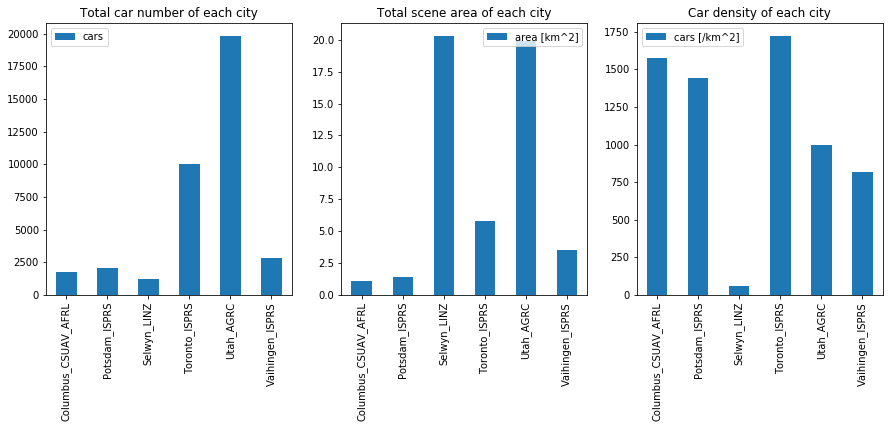

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(5* 3, 5))
stats_df.plot(ax=axes[0], kind='bar', y=['cars'], title='Total car number of each city')
stats_df.plot(ax=axes[1], kind='bar', y=['area [km^2]'], title='Total scene area of each city')
stats_df.plot(ax=axes[2], kind='bar', y=['cars [/km^2]'], title='Car density of each city')

# Extract the same statistics from each scene of Utah region

In [8]:
city_utah = 'Utah_AGRC.txt'

scenes_utah = get_scenes(city_root, city_utah)
stats_utah = extract_city_stats(data_root, scenes_utah, False)

stats_utah_df = gen_stats_dataframe(stats_utah)
stats_utah_df

,area [km^2],cars,cars [/km^2]
12TVK220980-CROP,1.032154,813,787.672850
12TVL120100-CROP,1.742400,61,35.009183
12TVL160640-CROP,1.172726,2860,2438.763158
12TVL160660-CROP,0.777395,608,782.099301
12TVL180140,3.999800,806,201.510075
12TVL200180,3.999800,751,187.759388
12TVL220180-CROP,1.336105,149,111.518197
12TVL220360-CROP,1.827769,546,298.724871
12TVL240120,3.999800,13213,3303.415169


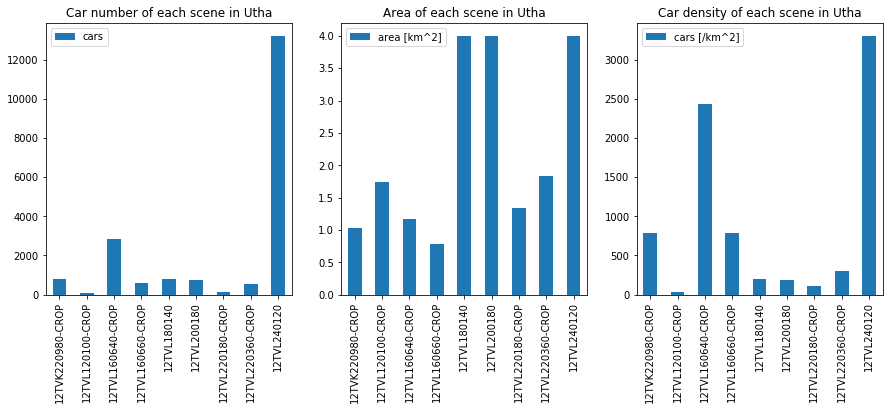

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(5* 3, 5))
stats_utah_df.plot(ax=axes[0], kind='bar', y=['cars'], title='Car number of each scene in Utha')
stats_utah_df.plot(ax=axes[1], kind='bar', y=['area [km^2]'], title='Area of each scene in Utha')
stats_utah_df.plot(ax=axes[2], kind='bar', y=['cars [/km^2]'], title='Car density of each scene in Utha')